In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

In [4]:
print('''
For DiD we measured effectiveness of marketing campaign between two cities. However, what if the two cities were substantially different?

This leads us to the idea of synthetic controls. Forging fake data to similar to our group of interest to measure the effective.

To see this, let's do a case study of estimating effect of cigarette taxation on consumption.
Idea is higher tax--->Lower consumption. Is this true? to what degree
''')


For DiD we measured effectiveness of marketing campaign between two cities. However, what if the two cities were substantially different?

This leads us to the idea of synthetic controls. Forging fake data to similar to our group of interest to measure the effective.

To see this, let's do a case study of estimating effect of cigarette taxation on consumption.
Idea is higher tax--->Lower consumption. Is this true? to what degree



In [10]:
url='https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/smoking.csv'
cigar = (pd.read_csv(url)
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()


,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


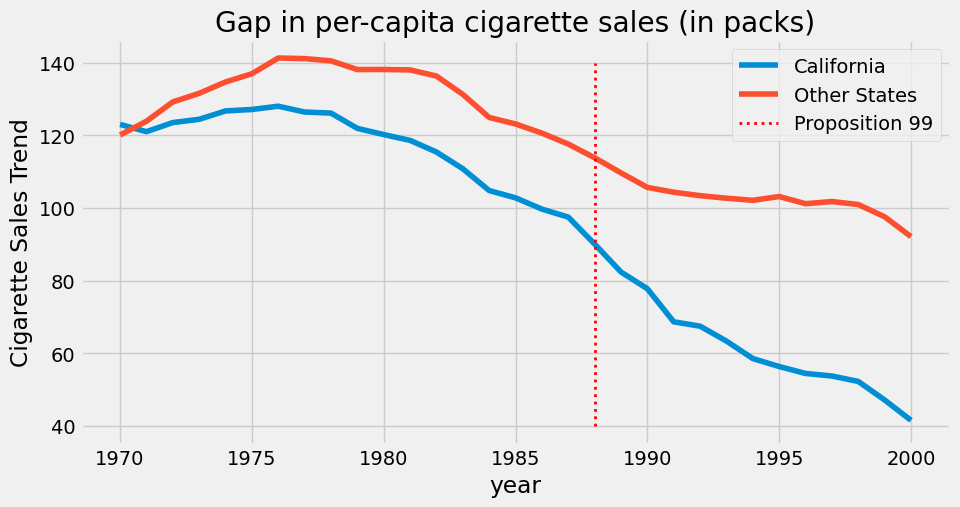

In [21]:
# Create the subplot
fig, ax = plt.subplots(figsize=(10, 5))

(cigar
 .assign(california=lambda x: np.where(x["california"], "California", "Other States"))
 .groupby(["year", "california"])["cigsale"]
 .mean()
 .unstack("california")
 .plot(ax=ax))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, color="red", label="Proposition 99")

# Labeling and legend
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend()
plt.show()

In [22]:
print('''From this graph, we can objectively see California spend sless on cigarettes than other states. And after our intervention, it decreases furthermore.
However , can we claim its from the policy? and can we measure this effect?

To do so, we can introduce the idea of synthetic control to create a "fake" california to act as a comparison

      ''')

From this graph, we can objectively see California spend sless on cigarettes than other states. And after our intervention, it decreases furthermore.
However , can we claim its from the policy? and can we measure this effect?

To do so, we can introduce the idea of synthetic control to create a "fake" california to act as a comparison

      


In [24]:
print('''
Goal: How do we build a fake california?
TLDR: We use a linear regression to create a model to estimate california with the other states, then use this to generate forward for time.

''')


Goal: How do we build a fake california?
TLDR: We use a linear regression to create a model to estimate california with the other states, then use this to generate forward for time.




In [25]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3   ...          37          38  \
        year                                      ...                           
cigsale 1970   89.800003  100.300003  123.000000  ...  114.500000  106.400002   
        1971   95.400002  104.099998  121.000000  ...  111.500000  105.400002   
        1972  101.099998  103.900002  123.500000  ...  117.500000  108.800003   
        1973  102.900002  108.000000  124.400002  ...  116.599998  109.500000   
        1974  108.199997  109.699997  126.699997  ...  119.900002  111.800003   

state                 39  
        year              
cigsale 1970  132.199997  
        1971  131.699997  
        1972  140.000000  
        1973  141.199997  
        1974  145.800003  

[5 rows x 39 columns]

In [27]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

In [28]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

In [29]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

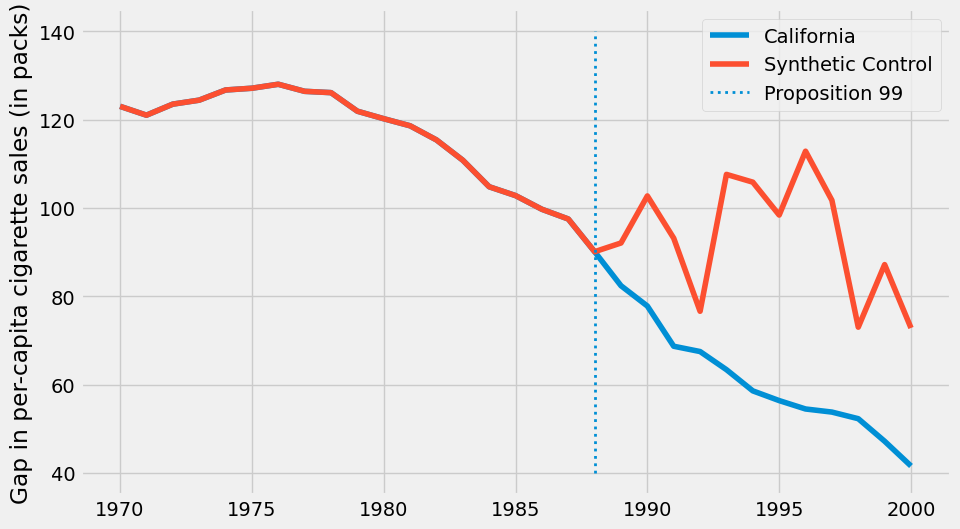

In [32]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

In [33]:
print('''The heck? What's with our graph. The pre intervention period syntehtic and cali are the same. Clear overfitting, and after it goes up and down a lot, a lot of variance.

This shows the danger of extrapolation. To combat this, we can do interpolation, by having the weights be positive and usm up to 1 to create a convex combination


''')

The heck? What's with our graph. The pre intervention period syntehtic and cali are the same. Clear overfitting, and after it goes up and down a lot, a lot of variance.

This shows the danger of extrapolation. To combat this, we can do interpolation, by having the weights be positive and usm up to 1 to create a convex combination





In [36]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

lambda x: np.sum(x) - 1
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [37]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000236


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [38]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)


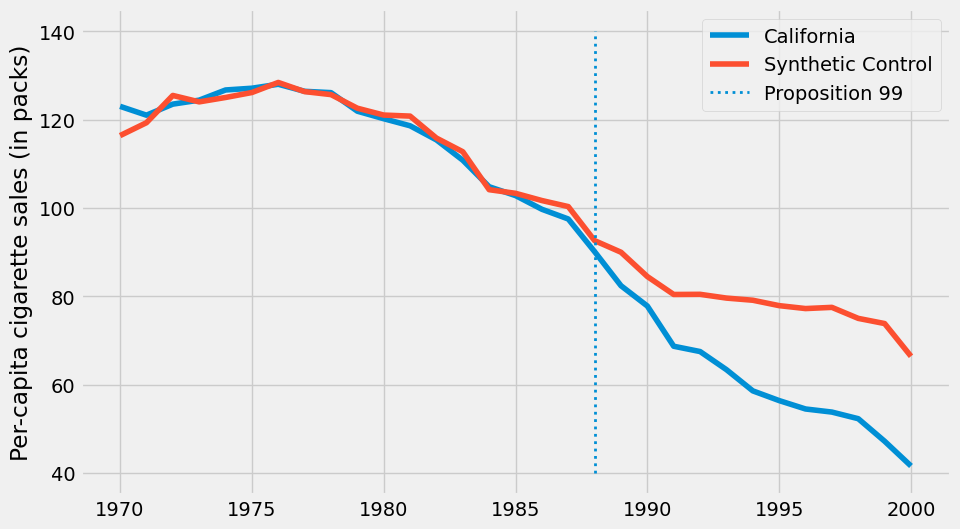

In [39]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();


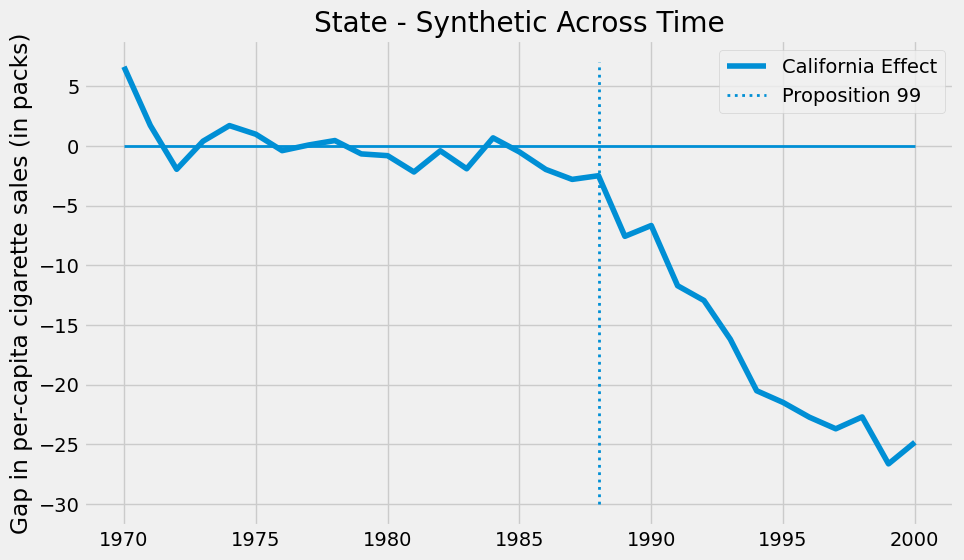

In [40]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

In [ ]:
print('''

Getting to significance: Fisher Exact Test
''')

In [41]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

In [42]:
synthetic_control(1, cigar).head()


,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


In [43]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [44]:
synthetic_states[0].head()


,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


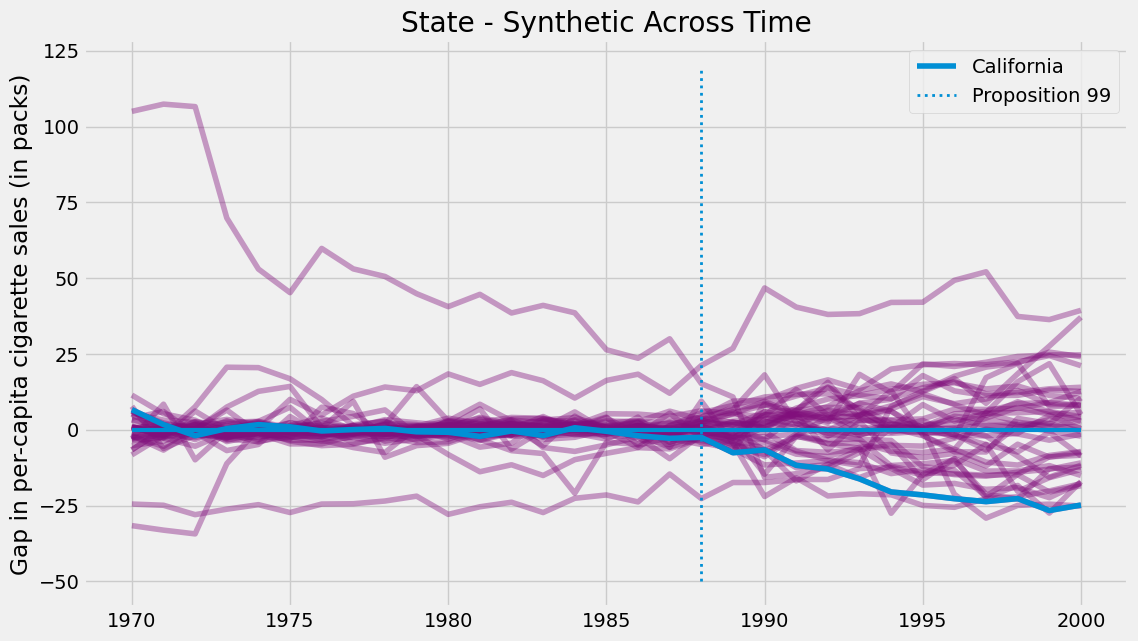

In [45]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

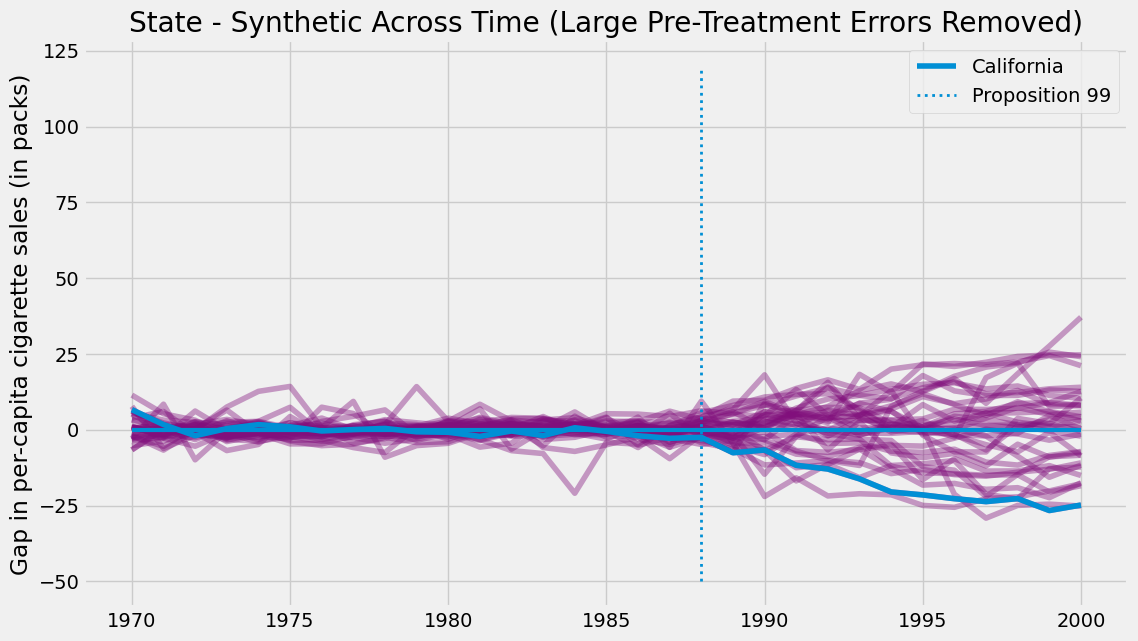

In [46]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

In [47]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.830159744091695


array([  5.79715887,   0.8945899 , -24.83015974,  -7.16628123,
       -10.92204859,  37.11640554, -15.06971705,  -0.49805125,
       -18.45795056,  21.13366449,  12.57782758,  -1.47547828,
        10.49627385, -11.67012334,   4.29850825,   8.04811409,
        14.0232241 ,   8.25002726,   0.32576356,  -8.40826864,
        -2.12402708,  -7.42865049,   2.96157493,  24.10478122,
         4.25211769, -17.75844573,   7.93334015,   2.81640125,
        12.64955948, -17.47677513, -25.16040944, -12.26469128,
        24.69067344,  10.3629958 ,  -8.59880378])

In [48]:
np.mean(np.array(effects) < calif_effect)


0.02857142857142857

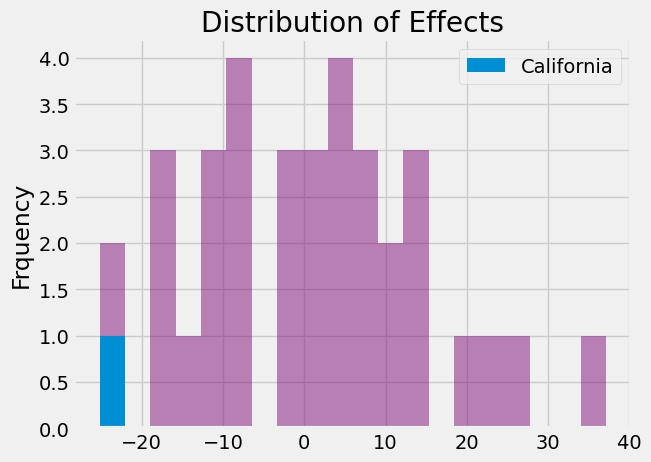

In [49]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();